In [1]:
# import ceda
# import importlib
# importlib.reload(ceda)

In [2]:
# # temp storage for existing file extensions
# href.endswith('.zip')
# or href.endswith('.txt') 
# or href.endswith('.html')  
# or href.endswith('.pdf')
# or href.endswith('.kml')
# or href.endswith('.ict')
# or href.endswith('.dat')
# or href.endswith('.xls')
# or href.endswith('.ps')

In [14]:
import iris
import matplotlib.pyplot as plt
import numpy as np

from bs4 import BeautifulSoup
import requests
import os
import sys

# clear cell outputs when private information is displayed
from IPython.display import clear_output
HIDE_SECRET_OUTPUT = True

In [8]:
# read environment file
env_vars = {}

with open(".env") as f:
    for line in f:
        key, value = line.strip().split("=", 1)
        env_vars[key] = value

print(env_vars)
if HIDE_SECRET_OUTPUT:
    clear_output()

In [10]:
# load environment variables
CERT_SECRET = env_vars["CEDA_CERTIFICATE_DIRECTORY"]

In [15]:
cert_dir = CERT_SECRET # certificate file location generated by https://help.ceda.ac.uk/article/4442-ceda-opendap-scripted-interactions
visited_urls = set() # global sets to allow access in functions during recursion
download_links = set()
start_data_dir = './data_ceda_aircraft' # root directory for downloaded content
    
def crawl_directory(url, start_data_dir):
    if url in visited_urls:
        return
    
    visited_urls.add(url)
    
    response = requests.get(url, cert=(cert_dir))
    
    soup = BeautifulSoup(response.content, 'html.parser') # parse the content, returns soup object
    
    if soup is None: # if nothing is found in the htmlparse, end
        return
    
#     os.makedirs(os.path.dirname(start_data_dir), exist_ok=True) # CREATE A NEW DIRECTORY/subdirectory in the download folder FOR EACH DIRECTORY ONLINE
    
#     with open(os.path.join(start_data_dir, 'page.html'), "w", errors='ignore') as f:   # WRITE THE CONTENTS OF THE DIRECTORY IN THE DIRECTORY WITH A PAGE.HTML FILE FOR NAVIGATION
#         f.write(str(soup))                                                             # (does not work without previous os.makdirs in most cases)
    
    for link in soup.find_all('a'):#hrefs exist in anchor elements
        if link.has_attr('href'):
            href = link['href'] #only explore links
        else:
            continue
        
        if(
            href == '../' 
        ): # don't go up in directories
            continue
        elif(href.endswith('/')): # if the link is a further directory
            if(
                'non' in href
                or href=='core_processed_standard/'
                or href=='core_processed_cloud_physics/'
                or 'temp' in href
                or 'raw' in href
                or 'video' in href
            ): # ignore known undesirable directories in our specific use-case
                continue
            if(len(href)==5): # print hrefs that are years just for easy progress tracking
                print("Looking in year:", href)
                if href == '2004/' or href == '2005/' or href == '2006/': #doesn't contain any desired files
                    continue
            # look in the directory
            crawl_directory(os.path.join(url, href), os.path.join(start_data_dir, href))
        elif(href.endswith('1hz.nc')): # save diserable files
            
            #don't download if there is a more recent version
            all_links = soup.find_all('a')
            all_hrefs = list([ link['href'] for link in all_links ])
            all_1hz = [desired_nc_file for desired_nc_file in all_hrefs if '1hz.nc' in desired_nc_file]
            # add all the 1hz files in this directory to the visited urls section (duplicates current href, but doesn't cause issue)
            for nc_1hz in all_1hz:
                visited_urls.add(os.path.join(url, nc_1hz))
            #add only the most recent revision to links that are kept
            all_1hz = sorted(all_1hz)
            most_recent_1hz = all_1hz[-1]
            download_links.add(os.path.join(url, most_recent_1hz)) # if chosen to mirror the directory setup as is online, good idea to just download the file instead of save download link
    
file_start_url = 'https://dap.ceda.ac.uk/badc/faam/data'
print('starting crawl')
crawl_directory(file_start_url, start_data_dir)
print('crawl end')
#convert 1hz.nc set to sorted list
download_links = sorted(list(download_links))

# print(download_links)
print(len(download_links), "files found.")

starting crawl
Looking in year: 2004/
Looking in year: 2005/
Looking in year: 2006/
Looking in year: 2007/
Looking in year: 2008/
Looking in year: 2009/
Looking in year: 2010/
Looking in year: 2011/
Looking in year: 2012/
Looking in year: 2013/
Looking in year: 2014/
Looking in year: 2015/
Looking in year: 2016/
Looking in year: 2017/
Looking in year: 2018/
Looking in year: 2019/
Looking in year: 2020/
Looking in year: 2021/
Looking in year: 2022/
crawl end
1024 files found.


In [16]:
print(download_links)

['https://dap.ceda.ac.uk/badc/faam/data/2007/b285-apr-19/core_processed/core_faam_20070419_v001_r0_b285_1hz.nc', 'https://dap.ceda.ac.uk/badc/faam/data/2007/b289-apr-29/core_processed/core_faam_20070429_v001_r0_b289_1hz.nc', 'https://dap.ceda.ac.uk/badc/faam/data/2007/b293-jun-12/core_processed/core_faam_20070612_v001_r0_b293_1hz.nc', 'https://dap.ceda.ac.uk/badc/faam/data/2007/b294-jun-18/core_processed/core_faam_20070618_v001_r0_b294_1hz.nc', 'https://dap.ceda.ac.uk/badc/faam/data/2007/b295-jun-19/core_processed/core_faam_20070619_v001_r0_b295_1hz.nc', 'https://dap.ceda.ac.uk/badc/faam/data/2007/b296-jun-21/core_processed/core_faam_20070621_v001_r0_b296_1hz.nc', 'https://dap.ceda.ac.uk/badc/faam/data/2007/b297-jun-22/core_processed/core_faam_20070622_v001_r0_b297_1hz.nc', 'https://dap.ceda.ac.uk/badc/faam/data/2007/b298-jun-22/core_processed/core_faam_20070622_v001_r0_b298_1hz.nc', 'https://dap.ceda.ac.uk/badc/faam/data/2007/b299-jun-24/core_processed/core_faam_20070624_v001_r0_b299_

In [23]:
#create directory to store data
save_dir = start_data_dir + '/'
os.makedirs(os.path.dirname(save_dir), exist_ok=True)

In [24]:
progress_counter = 0
BREAK_ON_INITIAL_DOWNLOADS = True #Don't download a tonne of data, might destroy my directory allowance, choose better disk otherwise
for hzfile in download_links:
    if progress_counter % 25 == 0:
        print("Downloaded number of files:", progress_counter)
        if BREAK_ON_INITIAL_DOWNLOADS:
            if progress_counter > 0:
                break
    nc_file_name = hzfile.split('/')[-1]
    response_content = requests.get(hzfile, cert=(CERT_SECRET)).content
    with open(f"{save_dir}{nc_file_name}", 'wb') as f:
        f.write(response_content)
    progress_counter+=1

Downloaded number of files: 0
Downloaded number of files: 25


In [25]:
cubes = iris.load(f"{start_data_dir}/{download_links[0].split('/')[-1]}") # get the first file downloaded
cubes

[<iris 'Cube' of Flag for rate-of-change of INS heading / (1) (-- : 37243; -- : 1)>,
<iris 'Cube' of Mole fraction of Nitrogen Monoxide (NO) in air from the TECO 42 instrument       / (ppb) (-- : 37243; -- : 1)>,
<iris 'Cube' of Flag for Uncorrected red total scattering coefficient from TSI 3563 nephelometer. / (1) (-- : 37243; -- : 1)>,
<iris 'Cube' of Flag for True air temperature from the Rosemount deiced temperature sensor. / (1) (-- : 37243; -- : 1)>,
<iris 'Cube' of Flag for Northward wind component from turbulence probe and Kalman-filtered INU / (1) (-- : 37243; -- : 1)>,
<iris 'Cube' of Solar zenith derived from aircraft position and time.                            / (degree) (-- : 37243; -- : 1)>,
<iris 'Cube' of Corrected downward short wave irradiance, red dome                               / (W m-2) (-- : 37243; -- : 1)>,
<iris 'Cube' of Flag for Radar height from the aircraft radar altimeter. / (1) (-- : 37243; -- : 1)>,
<iris 'Cube' of Flag for Internal sample temperatur

In [26]:
# <iris 'Cube' of altitude / (m) (-- : 21230; -- : 1)>,
# <iris 'Cube' of latitude / (degree_north) (-- : 21230; -- : 1)>,
# <iris 'Cube' of longitude / (degree_east) (-- : 21230; -- : 1)>,
lon_vals = None
lat_vals = None
alt_vals = None
for cube in cubes:
    if cube.name()=='altitude':
        alt_vals = cube.data
for cube in cubes:
    if cube.name()=='latitude':
        lat_vals = cube.data
for cube in cubes:
    if cube.name()=='longitude':
        lon_vals = cube.data

In [27]:
print(lon_vals.shape)
print(type(lon_vals))

(37243, 1)
<class 'numpy.ma.core.MaskedArray'>


In [28]:
lon_vals = np.ma.filled(lon_vals, np.NaN).flatten()
lat_vals = np.ma.filled(lat_vals, np.NaN).flatten()
alt_vals = np.ma.filled(alt_vals, np.NaN).flatten()

Text(0.5, 0.92, 'Reported lon, lat, altitude data from flight path')

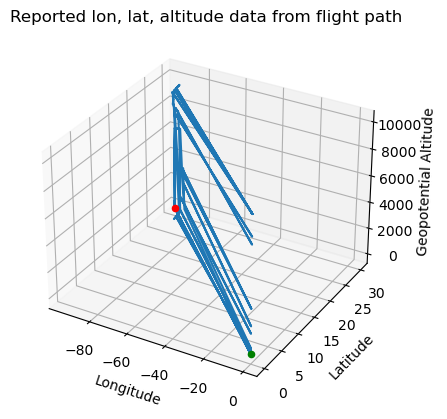

In [29]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(lon_vals, lat_vals, alt_vals)
ax.scatter(lon_vals[0], lat_vals[0], alt_vals[0], c='Green', label='Start')
ax.scatter(lon_vals[-1], lat_vals[-1], alt_vals[-1], c='Red', label='Stop')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Geopotential Altitude')
plt.title('Reported lon, lat, altitude data from flight path')

Text(0.5, 1.0, 'Reported lon, lat from flight path')

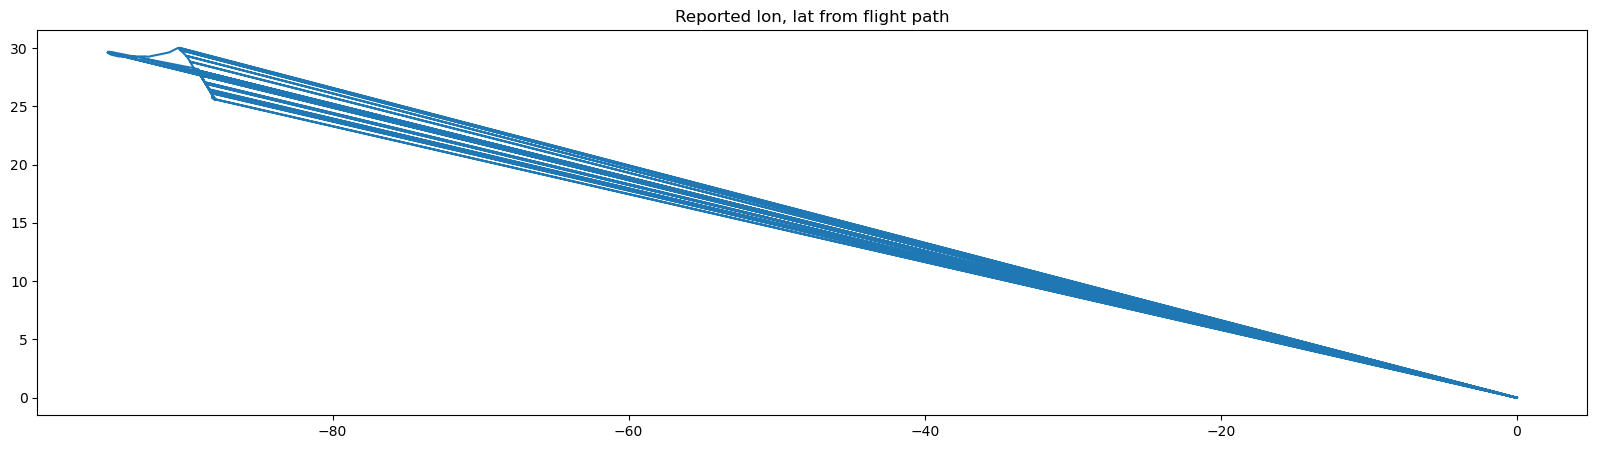

In [30]:
fig = plt.figure(figsize=(20,5))
plt.plot(lon_vals, lat_vals)

plt.title('Reported lon, lat from flight path')